# Extended Kalman Filter

Aircraft range problem as in Lecture 14

Includes both range and elevation sensing capabilties

In [1]:
from os.path import exists
file_exists = exists('basic_material.py')

if (not file_exists):
  !wget -O basic_material.py https://www.dropbox.com/s/o48uhuwah8n2xww/basic_material.py?dl=0
%run basic_material

try:
    %reload_ext autoreload
except:
    %load_ext autoreload
%autoreload 2

from math import sqrt, atan2
from scipy.linalg import expm, solve_discrete_lyapunov, sqrtm
from scipy import linalg as la
from scipy.integrate import odeint

#https://filterpy.readthedocs.io/en/latest/
try:
    from filterpy.kalman import KalmanFilter
except:
    %pip install filterpy
    from filterpy.kalman import KalmanFilter
from filterpy.kalman import ExtendedKalmanFilter

plt.rcParams['axes.grid'] = True
plt.style.use('fivethirtyeight') # For better style
plt.rcParams["figure.figsize"] = (8,5)

# setup diff random problems
np.random.seed(200)
np.random.seed(300)
np.random.seed(400)

Running Python: 3.8.16


## Form the measurements 

Check the derivatives - these are not not used automatically

In [20]:
# Noise terms
range_std = 3 # meters
vel_std = 0.25 # process noise on the velocity
radar_pos = (0., 0.) # xpos and y height

if 0:
    EASY = True # if EASY, then have 2 linear sensors
    elevation_angle_std = 10*range_std # fake height meas
else:
    EASY = False # 2 NL sensors
    Ne = 2 # degs of elev error
    elevation_angle_std = math.radians(Ne) # degs to rads

## Dynamics and Measurements

In [21]:
sx, sx_vel, sy, Range = sympy.symbols('x, x_vel, y, Range')
state = sympy.Matrix([sx, sx_vel, sy])
Range = sympy.sqrt(sx**2 + sy**2)
Bearing = sympy.atan2(sy,sx)

H = sympy.Matrix([Range])
H2 = sympy.Matrix([Bearing])

J = H.jacobian(state)
J2 = H2.jacobian(state)

print('\n Filter state')
display(state.T)
print('\n Range')
display(H)
print('\n Range gradient')
display(J)
print('\n Bearing')
display(H2)
print('\n Bearing gradient')
display(J2)


 Filter state


Matrix([[x, x_vel, y]])


 Range


Matrix([[sqrt(x**2 + y**2)]])


 Range gradient


Matrix([[x/sqrt(x**2 + y**2), 0, y/sqrt(x**2 + y**2)]])


 Bearing


Matrix([[atan2(y, x)]])


 Bearing gradient


Matrix([[-y/(x**2 + y**2), 0, x/(x**2 + y**2)]])

## Define a bunch of functions

In [22]:
# algorithm for finding discrete noise (see 7-16)
# for a cts A,Bw,Bu
def DiscretizeW(A,Bw,Wc,Bu,dt = 1):
    Nx = A.shape[0]

    # find Ad and Wd
    S = np.zeros([2*Nx,2*Nx])
    S[0:Nx,0:Nx] = -A
    S[0:Nx,Nx:2*Nx] = Bw@np.atleast_2d(Wc)@Bw.T
    S[Nx:2*Nx,Nx:2*Nx] = A.T
    CC = expm(S*dt)
    Ad = np.transpose(CC[Nx:2*Nx,Nx:2*Nx])
    Wd = Ad@CC[0:Nx,Nx:2*Nx]

    # now find Bd
    Nu = int(Bu.size/Nx)
    S = np.zeros([Nx+Nu,Nx+Nu])
    S[0:Nx,0:Nx] = A
    S[0:Nx,Nx:Nx+Nu] = Bu
    CC = expm(S*dt)
    Bd = CC[0:Nx,Nx:Nx+Nu]

    return Wd, Ad, Bd 

# From filterpy book
# https://share.cocalc.com/share/7557a5ac1c870f1ec8f01271959b16b49df9d087/Kalman-and-Bayesian-Filters-in-Python/10-Unscented-Kalman-Filter.ipynb?viewer=share
class ACSim:   
    def __init__(self, pos, vel, vel_std):
        self.pos = np.asarray(pos, dtype=float)
        self.vel = np.asarray(vel, dtype=float)
        self.vel_std = np.asarray(vel_std, dtype=float)        
        
    def update(self, dt):
        """ Compute and returns next position. Incorporates 
        random variation in velocity. """
        noise = sqrtm(rk.Q)@randn(3)
        self.pos[0] += self.vel[0] * dt + noise[0] 
        # process noise only on the horiz vel
        #self.vel[0] += randn(1) * self.vel_std * sqrt(dt) # small dt approx 
        self.vel[0] += noise[1] # small dt approx 
        return self.pos

def f_radar(x, dt):
    global Ad
    """ state transition function for a constant velocity 
    aircraft with state vector [x, velocity, altitude]'"""
    return Ad @ x

def h_radar(x):  # clean range meas
    global radar_pos
    diff = np.subtract([x[0], x[2]], radar_pos) # not a ftn of vel which is x[1]
    if EASY:
        rng = diff[0]
        brg = diff[1]
    else:
        rng = norm(diff)
        brg = np.arctan2(diff[1], diff[0])
    return [rng, brg]

def h_radar_noisy(x,R): 
    rng, brg = h_radar(x)
    noise = sqrtm(R)@randn(2)
    rng += noise[0]
    brg += noise[1]
    return [rng, brg]

def HJacobian_at(x):
    global radar_pos
    """ compute Jacobian of H matrix at x """
    if EASY:
        H = array ([[1, 0., 0],
                  [0, 0., 1]])      
    else:
        diff = np.subtract([x[0], x[2]], radar_pos) # not a ftn of vel which is x[1]
        denom = norm(diff)
        H = array ([[diff[0]/denom, 0., diff[1]/denom],
                  [-diff[1]/denom**2, 0., diff[0]/denom**2]])
    return H

## Setup the EKF

In [23]:
dt = 0.1 
Tf = 50+dt
time = np.arange(0, Tf, dt)

ac_pos = (-500., 1000.) # x h
ac_vel = (20., 0.) # vx vh
ac = ACSim(ac_pos, ac_vel, vel_std)

In [24]:
# algorithm for finding discrete noise
A = array([[0, 1, 0],[0, 0, 0],[0, 0, 0]])
Nx = A.shape[0]
Bw = array([[0, 0],[1, 0],[0, 1]]) 
Nz = 2 # number of process noise inputs

In [25]:
# define the EKF structure 
rk = ExtendedKalmanFilter(dim_x = Nx, dim_z = Nz)
# vel_std**2 as process noise on v and small ficticious noise added to h
Wc = np.array([[vel_std**2, 0],[0, (vel_std**2)/10]])
rk.Q,rk.F,_ = DiscretizeW(A,Bw,Wc,Bw,dt)
rk.R = np.diag([range_std**2, elevation_angle_std**2]) # sensing noise

# make an imperfect starting guess
x0 = np.array([ac.pos[0], ac.vel[0], ac.pos[1]])
rk.x = copy.deepcopy(x0) # actual state as the mean
rk.P = np.diag([100**2, 2**2, 200**2]) # some smallish initial variances 
rk.x += sqrtm(rk.P)@randn(3) # initial filter state 

Radar_store, Qs, xs, X = [], [], [], [] # storage
xs.append(rk.x)     
Radar_store.append(h_radar_noisy(x0, rk.R)) # meas
X.append([ac.pos[0], ac.vel[0], ac.pos[1], ac.vel[1]]) # actual
Qs.append(np.diag(sqrtm(rk.P))) # store std 

for _ in time[1:]:
    ac.update(dt)
    X.append([ac.pos[0], ac.vel[0], ac.pos[1], ac.vel[1]])
    z = h_radar_noisy([ac.pos[0], ac.vel[0], ac.pos[1]], rk.R)
    rk.update([z[0], z[1]], HJacobian_at, h_radar)
    xs.append(rk.x)
    rk.predict()
    Radar_store.append(np.array(z)) # measurements
    Qs.append(np.diag(sqrtm(rk.P))) # covariance

## Plotting

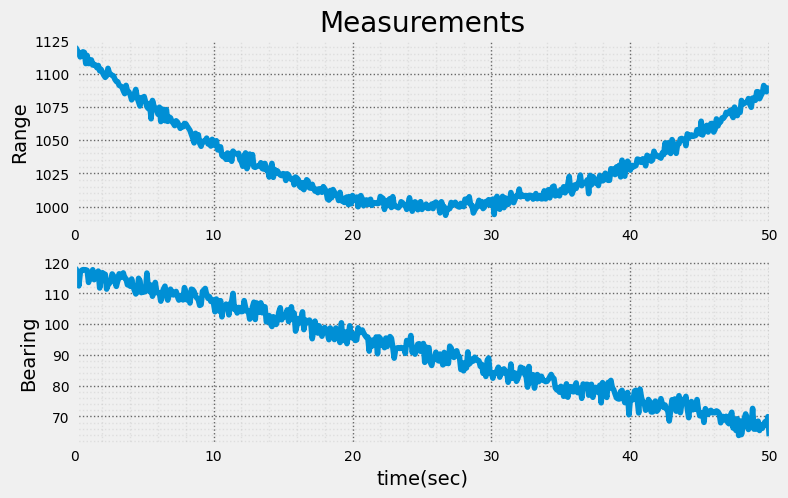

In [26]:
xs = np.asarray(xs)
Radar_store = np.asarray(Radar_store)
X = np.asarray(X)
Qs = np.asarray(Qs)

plt.figure(2,figsize=(8,5))
plt.subplot(211)
plt.plot(time,Radar_store[0:,0],label='Range')
plt.title('Measurements')
plt.ylabel('Range')
#plt.ylim([500, 1500])
plt.xlim([0, Tf])
nicegrid()
plt.subplot(212)
if EASY:
    plt.plot(time,Radar_store[0:,1],label='Y2')
    plt.ylabel('Height Meas')
else:
    plt.plot(time,180/np.pi*Radar_store[0:,1],label='Bearing')
    plt.ylabel('Bearing')
    #plt.ylim([0, 180])
plt.xlabel('time(sec)')
plt.xlim([0, Tf])
nicegrid()
plt.tight_layout
if not EASY:
    plt.savefig('figs/EKF1.png',dpi=600, format="png",transparent=True)
plt.show()

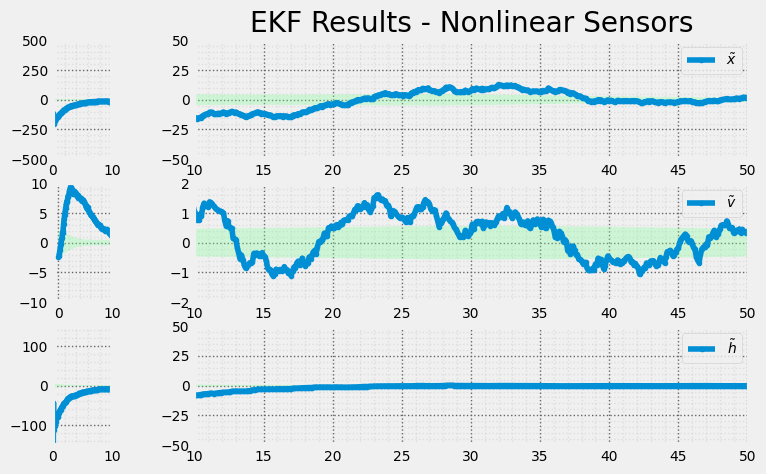

In [27]:
fig = plt.figure(figsize=(8,5))

ax1 = plt.subplot2grid((3,10), (0,0), rowspan=1, colspan = 1)
ax11 = plt.subplot2grid((3,10), (0,2), rowspan=1, colspan = 8)
ax1.plot(time, (xs[0:,0]-X[0:,0]),'.-',label=r'$\tilde x $')
ax1.fill_between(time, -Qs[0:,0], Qs[0:,0],alpha=0.3, facecolor='#7EFF99',
    lw=0, linestyle='dashdot', antialiased=True)
ax1.set_ylim([-500, 500])
ax1.set_xlim([0, 10])
nicegrid(ax1)
ax11.plot(time, (xs[0:,0]-X[0:,0]),'.-',label=r'$\tilde x $')
ax11.fill_between(time, -Qs[0:,0], Qs[0:,0],alpha=0.3, facecolor='#7EFF99',
    lw=0, linestyle='dashdot', antialiased=True)
ax11.legend(loc='best')
ax11.set_ylim([-50, 50])
ax11.set_xlim([10, Tf])
nicegrid(ax11)
if EASY:
    ax11.set_title('EKF Results - Linear Sensors')
else:
    ax11.set_title('EKF Results - Nonlinear Sensors')

ax2 = plt.subplot2grid((3,10), (1,0), rowspan=1, colspan = 1)
ax21 = plt.subplot2grid((3,10), (1,2), rowspan=1, colspan = 8)
ax2.plot(time, (xs[0:,1]-X[0:,1]),'.-',label=r'$\tilde v $')
ax2.fill_between(time, -Qs[0:,1], Qs[0:,1],alpha=0.3, facecolor='#7EFF99',
    lw=0, linestyle='dashdot', antialiased=True)
ax2.set_ylim([-10, 10])
ax2.set_xlim([-1, 10])
nicegrid(ax2)
ax21.plot(time, (xs[0:,1]-X[0:,1]),'.-',label=r'$\tilde v $')
ax21.fill_between(time, -Qs[0:,1], Qs[0:,1],alpha=0.3, facecolor='#7EFF99',
    lw=0, linestyle='dashdot', antialiased=True)
ax21.legend(loc='best')
ax21.set_ylim([-2, 2])
ax21.set_xlim([10, Tf])
nicegrid(ax21)

ax3 = plt.subplot2grid((3,10), (2,0), rowspan=1, colspan = 1)
ax31 = plt.subplot2grid((3,10), (2,2), rowspan=1, colspan = 8)
ax3.plot(time, (xs[0:,2]-X[0:,2]),'.-',label=r'$\tilde h $')
ax3.fill_between(time, -Qs[0:,2], Qs[0:,2],alpha=0.3, facecolor='#7EFF99',
    lw=0, linestyle='dashdot', antialiased=True)
ax3.set_ylim([-150, 150])
ax3.set_xlim([0, 10])
nicegrid(ax3)
ax31.plot(time, (xs[0:,2]-X[0:,2]),'.-',label=r'$\tilde h $')
ax31.fill_between(time, -Qs[0:,2], Qs[0:,2],alpha=0.3, facecolor='#7EFF99',
    lw=0, linestyle='dashdot', antialiased=True)
ax31.legend(loc='best')
ax31.set_ylim([-50, 50])
ax31.set_xlim([10, Tf])
nicegrid(ax31)

plt.tight_layout
if EASY:
    plt.savefig('figs/EKF2_lin.png',dpi=600, format="png",transparent=True)
else:
    plt.savefig('figs/EKF2_nl.png',dpi=600, format="png",transparent=True)
plt.show()